In [1]:
import os
import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# helpers
from utils import get_contours_from_segmasks, get_contour_stats

In [2]:
vid_dir = "results/corona"
vid_path = f"./data/{vid_dir}/"
vid_filename = "2024_0126_162412_122_subclip_18sec_ts41-te59_cropped.mp4"
vid_filepath = f"{vid_path}{vid_filename}"

vid_extension = "." + vid_filename.split(".")[-1]
vid_filename = vid_filename.split(".")[0]


vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"
seg_mask_path = f"./data/{vid_dir}/{vid_filename}_masks" 

video = cv2.VideoCapture(vid_filepath)
fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
resolution = (height,width)
video.release()
print(fps, resolution)

# Adjust resolution depending on frame rate > PUT INTO A HELPER
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Construct output figure path
save_figure_path = f"{vid_path}/{vid_filename}"
os.makedirs(save_figure_path, exist_ok=True)

# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Total Frames
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
num_frames = len(frames)

print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)


24 (900, 800)
UHD, pixel_per_real_width =  0.4
num_frames: 432 ; save_figure_path: ./data/results/corona//2024_0126_162412_122_subclip_18sec_ts41-te59_cropped ; fps: 24 ; resolution: (900, 800)


In [3]:
# PUT INTO HELPER
EXTRACT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5  # correspond to seg-masks

if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True) # maybe check this here and do not extract if already present?!
    video = cv2.VideoCapture(vid_filepath)
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

# RETRACTION
- frames 0 to 44 as df

In [4]:
# Construct the dataframe
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

# Load in the segmentation masks and find contrours
segmentation_mask_filepaths = df["mask_fpath"].tolist()

# :44 - retract, 84:220 - extend
frame_idx = 44 
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths[:frame_idx])

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample > PUT INTO HELPER
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
df = df[:frame_idx]
num_frames = len(df)
print("final num_frames:", num_frames)

df.head(5)

final num_frames: 44


,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,0,0.000000,./data/results/corona/2024_0126_162412_122_sub...,254.0,664.0,14.5,28.0,0.517857,15.071068,0.571429,175.076981,NaN,./data/images/2024_0126_162412_122_subclip_18s...,1
1,1,0.041763,./data/results/corona/2024_0126_162412_122_sub...,256.0,678.0,23.5,54.0,0.435185,20.727922,1.500000,85.690292,14.142136,./data/images/2024_0126_162412_122_subclip_18s...,0
2,2,0.083527,./data/results/corona/2024_0126_162412_122_sub...,375.0,455.0,68202.5,205758.0,0.331469,1481.623578,0.881988,39.034420,252.764713,./data/images/2024_0126_162412_122_subclip_18s...,0
3,3,0.125290,./data/results/corona/2024_0126_162412_122_sub...,376.0,454.0,68250.0,207462.0,0.328976,1488.694645,0.874743,39.032520,1.414214,./data/images/2024_0126_162412_122_subclip_18s...,0
4,4,0.167053,./data/results/corona/2024_0126_162412_122_sub...,379.0,456.0,69183.5,209657.0,0.329984,1501.280435,0.869654,38.956573,3.605551,./data/images/2024_0126_162412_122_subclip_18s...,0


# Extension
- frames 84 to 220 as df2

In [11]:
df2 = pd.DataFrame(frames, columns=["frame"])
df2["time"] = np.linspace(0, len(df2) / fps, len(df2))
df2["mask_fpath"] = mask_filepaths
df2 = df2[84:220].reset_index()

df2

,index,frame,time,mask_fpath
0,84,84,3.508121,./data/results/corona/2024_0126_162412_122_sub...
1,85,85,3.549884,./data/results/corona/2024_0126_162412_122_sub...
2,86,86,3.591647,./data/results/corona/2024_0126_162412_122_sub...
3,87,87,3.633411,./data/results/corona/2024_0126_162412_122_sub...
4,88,88,3.675174,./data/results/corona/2024_0126_162412_122_sub...
...,...,...,...,...
131,215,215,8.979118,./data/results/corona/2024_0126_162412_122_sub...
132,216,216,9.020882,./data/results/corona/2024_0126_162412_122_sub...
133,217,217,9.062645,./data/results/corona/2024_0126_162412_122_sub...
134,218,218,9.104408,./data/results/corona/2024_0126_162412_122_sub...


In [15]:
# Construct the dataframe
df2 = pd.DataFrame(frames, columns=["frame"])
df2["time"] = np.linspace(0, len(df2) / fps, len(df2))
df2["mask_fpath"] = mask_filepaths

# Load in the segmentation masks and find contrours
segmentation_mask_filepaths2 = df2["mask_fpath"].tolist()

# :44 - retract, 84:220 - extend
contour_list2 = get_contours_from_segmasks(segmentation_mask_filepaths2[84:220])

# Get contour stats
df2_ = get_contour_stats(contour_list2) # add xtime but beware of NaN???!!! if area <5
df2 = df2[84:220].reset_index()


# Concat df2s
df2 = pd.concat([df2, df2_], axis=1)
df2["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(84,220)]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df2["frame_shown"] = 0
df2.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample > PUT INTO HELPER
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors2 = [cmap(i)[:3] for i in np.linspace(0, 1, len(df2))]
sub_colors2 = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index2 = np.arange(0, len(frame_subsample), 1)

# Check df2
num_frames2 = len(df2)
print("num_frames2:", num_frames2)

df2.head(5)

num_frames2: 136


,index,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,84,84,3.508121,./data/results/corona/2024_0126_162412_122_sub...,266,644,6358.5,14934,0.425773,434.859952,0.870229,34.008434,NaN,./data/images/2024_0126_162412_122_subclip_18s...,1
1,85,85,3.549884,./data/results/corona/2024_0126_162412_122_sub...,266,647,8253.5,18634,0.442927,458.457931,0.785714,28.260733,3.000000,./data/images/2024_0126_162412_122_subclip_18s...,0
2,86,86,3.591647,./data/results/corona/2024_0126_162412_122_sub...,267,643,9073.5,20320,0.446531,481.286358,0.793750,29.090282,4.123106,./data/images/2024_0126_162412_122_subclip_18s...,0
3,87,87,3.633411,./data/results/corona/2024_0126_162412_122_sub...,267,637,9994.5,22528,0.443648,511.286359,0.727273,21.619534,6.000000,./data/images/2024_0126_162412_122_subclip_18s...,0
4,88,88,3.675174,./data/results/corona/2024_0126_162412_122_sub...,266,628,10336.0,22750,0.454330,519.872146,0.686813,14.036028,9.055385,./data/images/2024_0126_162412_122_subclip_18s...,0


# Rotated df

In [17]:
rot_imgs = []
rot_masks = []
avg_rot = 39

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotatation parameters
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    angle = avg_rot
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask
    rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))

### Rot Video

In [72]:
SAVE_ROT_VIDEO = True
if SAVE_ROT_VIDEO:
    video_ = cv2.VideoWriter(f"{save_figure_path}/{vid_filename}_corona-retraction.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=fps, frameSize=(w, h), isColor=True)
    for nth, cimg in enumerate(rot_imgs):
        cv2.putText(cimg, f"frame{str(nth).zfill(zfill_)}", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 2)
        video_.write(cimg)
    cv2.destroyAllWindows()
    video_.release()

# Rotated df2

In [76]:
rot_imgs2 = []
rot_masks2 = []
avg_rot = 39

for nth, row in df2.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotatation parameters
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    angle = avg_rot
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask
    rot_imgs2.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks2.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))
    cv2.destroyAllWindows()


### Rot Video2

In [ ]:
SAVE_ROT_VIDEO2 = True
if SAVE_ROT_VIDEO2:
    video = cv2.VideoWriter(f"{save_figure_path}/{vid_filename}_corona-extension.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=fps, frameSize=(w, h), isColor=True)
    for nth, cimg2 in enumerate(rot_imgs2):
        cv2.putText(cimg2, f"frame{str(nth).zfill(zfill_)}", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 2)
        video.write(cimg2)
    cv2.destroyAllWindows()
    video.release()

## GET PARAMETERS
- length (L) and frontal width (W)
- ADD 60 fps to confirm that retraction happens mostly under 100ms
- frame 47 rüssel retractio starts, 107 corona fully extended and whirling  # have to add the missing first 84 frames

In [58]:

cmask = rot_masks[frame_trigger]
y, x = np.where(cmask)
print(np.min(y), np.max(y))


162 726


### RETRACTION

n_frames= 44 trigger_win (16, 36)


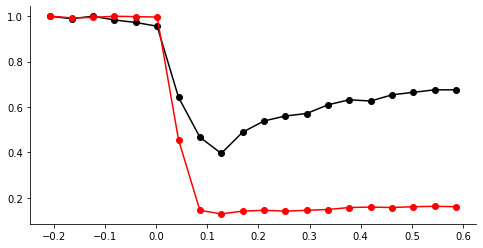

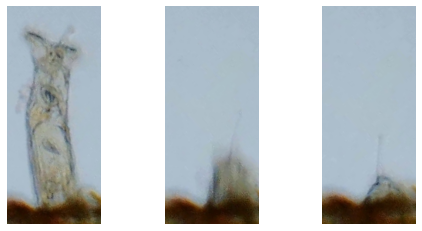

In [97]:
plt.rcParams['figure.facecolor'] = 'white'
t = df.time.tolist()
tframes = df.frame.tolist()

frame_trigger = 21
pre_, post_ = 5, 15
trigger_window = (frame_trigger - pre_, frame_trigger + post_) # window
print("n_frames=", len(tframes), "trigger_win", trigger_window)
#tshow_idx = 
L = [] # length
fw = [] # frotnal width
fmax = []
fw_frac = .3

for cmask in rot_masks:
    y, x = np.where(cmask)
    clength = np.max(y) - np.min(y)
    fmax.append(np.max(y))
    L.append(clength)
    front_yratio = np.max(y) * fw_frac
    yfront = np.where((y > front_yratio) & (y <= np.max(y)))
    fw.append(np.max(x[yfront]) - np.min(x[yfront]))
    

tshow = np.array(t[trigger_window[0]:trigger_window[1]]) - frame_trigger/fps
y_ = np.array(L[trigger_window[0]:trigger_window[1]])
y2_ = np.array(fw[trigger_window[0]:trigger_window[1]])
norm_fac = np.max(y_[:pre_-1])
norm_fac2 = np.max(y2_[:pre_-1])
y_ = y_ / norm_fac
y2_ = y2_ / norm_fac2

plt.figure(figsize=(8,4))
plt.plot(tshow, y2_, "-ko", label="frontal width")
plt.plot(tshow, y_, "-ro", label="length")

# MASKED IMAGE
cxlim = [300, 600]
cylim = [100, 800]

fig, ax = plt.subplots(1,3, squeeze=True, figsize=(8,4))
for i in range(3):
    ax[i].imshow(rot_imgs[frame_trigger + i]);
    ax[i].set_xlim(cxlim); ax[i].set_ylim(cylim);
    ax[i].invert_yaxis()
    ax[i].axis("off")# axis off

### EXTENSION
- Antennae is in the way of the rüssel unfortunately

n_frames= 136 trigger_win (50, 107)


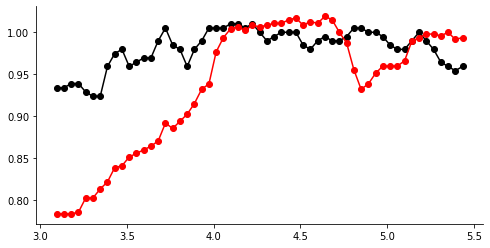

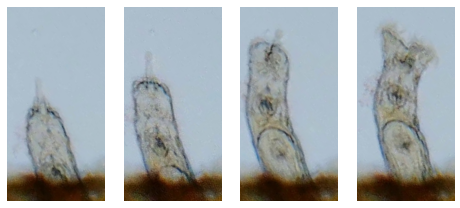

In [114]:
plt.rcParams['figure.facecolor'] = 'white'
t = df2.time.tolist()
tframes = df2.frame.tolist()

frame_trigger = 60  # 60 rüssel retract - 107 - fully extended corona
pre_, post_ = 10, 47
trigger_window = (frame_trigger - pre_, frame_trigger + post_) # window
print("n_frames=", len(tframes), "trigger_win", trigger_window)
#tshow_idx = 
L = [] # length
fw = [] # frotnal width
fmax = []
fw_frac = .3

for cmask in rot_masks2:
    y, x = np.where(cmask)
    clength = np.max(y) - np.min(y)
    fmax.append(np.max(y))
    L.append(clength)
    front_yratio = np.max(y) * fw_frac
    yfront = np.where((y > front_yratio) & (y <= np.max(y)))
    fw.append(np.max(x[yfront]) - np.min(x[yfront]))
    

tshow = np.array(t[trigger_window[0]:trigger_window[1]]) - frame_trigger/fps
y_ = np.array(L[trigger_window[0]:trigger_window[1]])
y2_ = np.array(fw[trigger_window[0]:trigger_window[1]])
# norm_fac = np.max(y_[:pre_-1])
# norm_fac2 = np.max(y2_[:pre_-1])
norm_fac = np.max(y_[-10:])
norm_fac2 = np.max(y2_[-10:])
y_ = y_ / norm_fac
y2_ = y2_ / norm_fac2

# Line plot
plt.figure(figsize=(8,4))
plt.plot(tshow, y2_, "-ko", label="frontal width")
plt.plot(tshow, y_, "-ro", label="length")

# Image plot
cxlim = [250, 550]
cylim = [200, 800]

fig, ax = plt.subplots(1,4, squeeze=True, figsize=(8,4))
for nth, i in enumerate([-30,0,30,50]):
    ax[nth].imshow(rot_imgs2[frame_trigger + i]);
    ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim);
    ax[nth].invert_yaxis()
    ax[nth].axis("off")

In [115]:
vid_dir = "results/corona"
vid_path = f"./data/{vid_dir}/"
vid_filename = "2024_0126_162729_125_subclip_4sec_ts33-te37_cropped.mp4"
vid_filepath = f"{vid_path}{vid_filename}"

vid_extension = "." + vid_filename.split(".")[-1]
vid_filename = vid_filename.split(".")[0]


vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"
seg_mask_path = f"./data/{vid_dir}/{vid_filename}_masks" 

video = cv2.VideoCapture(vid_filepath)
fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
resolution = (height,width)
video.release()
print(fps, resolution)

# Adjust resolution depending on frame rate > PUT INTO A HELPER
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Construct output figure path
save_figure_path = f"{vid_path}/{vid_filename}"
os.makedirs(save_figure_path, exist_ok=True)

# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Total Frames
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
num_frames = len(frames)

print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)


60 (350, 500)
FHD, pixel_per_real_width =  0.61
num_frames: 240 ; save_figure_path: ./data/results/corona//2024_0126_162729_125_subclip_4sec_ts33-te37_cropped ; fps: 60 ; resolution: (350, 500)


In [116]:
# PUT INTO HELPER
EXTRACT_FRAMES = True
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5  # correspond to seg-masks

if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True) # maybe check this here and do not extract if already present?!
    video = cv2.VideoCapture(vid_filepath)
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

In [118]:
# Construct the dataframe
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

# Load in the segmentation masks and find contrours
segmentation_mask_filepaths = df["mask_fpath"].tolist()

# frame 149 pre-retract, 150 - retract, 152 - fully gone
frame_idx = 152 
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths[:frame_idx])

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample > PUT INTO HELPER
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
df = df[:frame_idx]
num_frames = len(df)
print("final num_frames:", num_frames)

df.head(5)

final num_frames: 152


,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,0,0.000000,./data/results/corona/2024_0126_162729_125_sub...,281.0,210.0,12805.5,30084.0,0.425658,609.369619,1.57971,66.318596,NaN,./data/images/2024_0126_162729_125_subclip_4se...,1
1,1,0.016736,./data/results/corona/2024_0126_162729_125_sub...,281.0,211.0,12816.0,30003.0,0.427157,596.783832,1.59854,66.214981,1.0,./data/images/2024_0126_162729_125_subclip_4se...,0
2,2,0.033473,./data/results/corona/2024_0126_162729_125_sub...,280.0,211.0,12814.5,30003.0,0.427107,597.369619,1.59854,65.892105,1.0,./data/images/2024_0126_162729_125_subclip_4se...,0
3,3,0.050209,./data/results/corona/2024_0126_162729_125_sub...,280.0,211.0,12816.5,30003.0,0.427174,597.369618,1.59854,65.825806,0.0,./data/images/2024_0126_162729_125_subclip_4se...,0
4,4,0.066946,./data/results/corona/2024_0126_162729_125_sub...,280.0,211.0,12816.0,30003.0,0.427157,596.783833,1.59854,65.953911,0.0,./data/images/2024_0126_162729_125_subclip_4se...,0


In [119]:
rot_imgs = []
rot_masks = []
avg_rot = 66

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotatation parameters
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    angle = avg_rot
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask
    rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))

In [120]:
SAVE_ROT_VIDEO = True
if SAVE_ROT_VIDEO:
    video_ = cv2.VideoWriter(f"{save_figure_path}/{vid_filename}_corona-retraction_60fps.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=fps, frameSize=(w, h), isColor=True)
    for nth, cimg in enumerate(rot_imgs):
        cv2.putText(cimg, f"frame{str(nth).zfill(zfill_)}", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,255), 2)
        video_.write(cimg)
    cv2.destroyAllWindows()
    video_.release()

# Only two frames and then the rotifer is fully gone at 60fps! (due to not being able to see the entire animal) move on! retraction needs at least 60fps if not faster

### Need to find some 60fps for retraction process!